In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

file_paths = glob.glob("../data/*.gz")

file_paths

['../data/000000000006.csv.gz',
 '../data/000000000014.csv.gz',
 '../data/000000000016.csv.gz',
 '../data/000000000008.csv.gz',
 '../data/000000000004.csv.gz',
 '../data/000000000000.csv.gz',
 '../data/000000000012.csv.gz',
 '../data/000000000010.csv.gz',
 '../data/000000000002.csv.gz',
 '../data/000000000007.csv.gz',
 '../data/000000000015.csv.gz',
 '../data/000000000009.csv.gz',
 '../data/000000000005.csv.gz',
 '../data/000000000001.csv.gz',
 '../data/000000000013.csv.gz',
 '../data/000000000011.csv.gz',
 '../data/000000000003.csv.gz']

In [3]:
df = pd.concat(
    (pd.read_csv(file) for file in file_paths),
    ignore_index=True
)

print(f"Loaded {len(file_paths)} files")
print(f"Total rows: {len(df):,}")

Loaded 17 files
Total rows: 7,293,526


In [5]:
# Ensure datetime
df["event_date"] = pd.to_datetime(df["event_date"])
df["install_date"] = pd.to_datetime(df["install_date"])

# Compute lifecycle day
df["days_since_install"] = (
        df["event_date"] - df["install_date"]
).dt.days

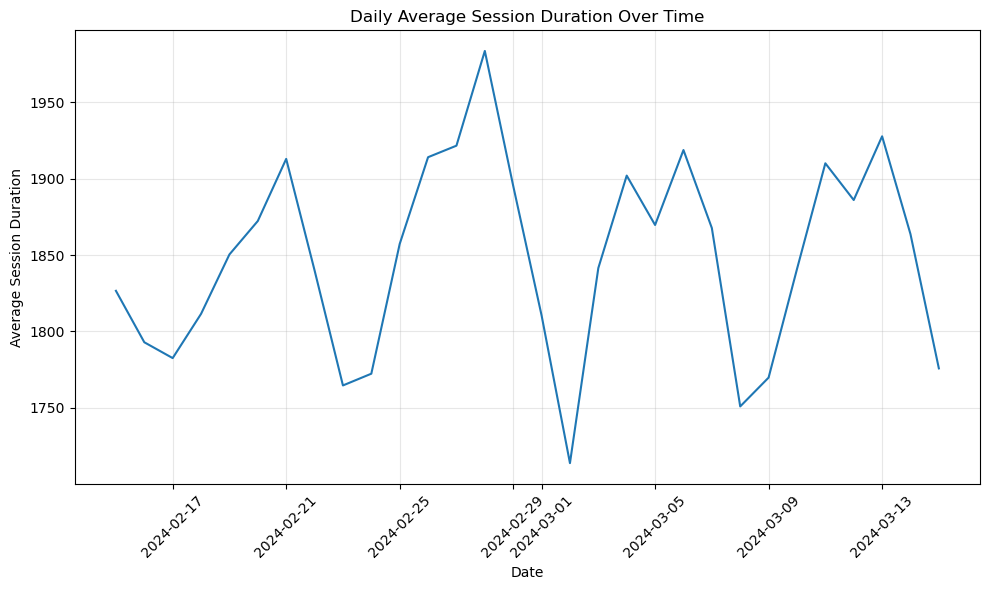

In [8]:
daily_avg_duration = (
    df.groupby("event_date")["total_session_duration"]
    .mean()
)

plt.figure(figsize=(10,6))

plt.plot(daily_avg_duration.index, daily_avg_duration.values)

plt.xlabel("Date")
plt.ylabel("Average Session Duration")
plt.title("Daily Average Session Duration Over Time")

plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

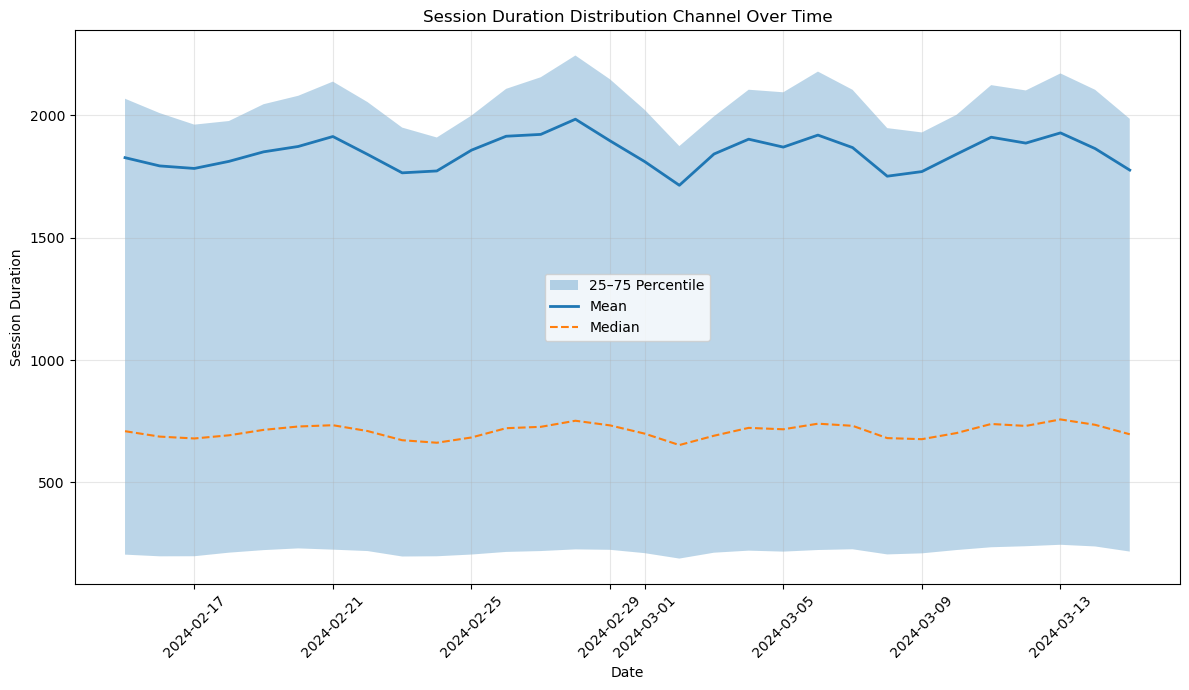

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure correct types
df["event_date"] = pd.to_datetime(df["event_date"])
df["total_session_duration"] = pd.to_numeric(
    df["total_session_duration"],
    errors="coerce"
)

# Drop NaNs
df_clean = df.dropna(subset=["total_session_duration"])

# Compute daily statistics (removed min & max)
daily_stats = (
    df_clean.groupby("event_date")["total_session_duration"]
    .agg(
        p25=lambda x: x.quantile(0.25),
        median="median",
        p75=lambda x: x.quantile(0.75),
        mean="mean"
    )
)

plt.figure(figsize=(12,7))

# IQR channel
plt.fill_between(
    daily_stats.index,
    daily_stats["p25"],
    daily_stats["p75"],
    alpha=0.3,
    label="25–75 Percentile"
)

# Mean & Median
plt.plot(daily_stats.index, daily_stats["mean"], linewidth=2, label="Mean")
plt.plot(daily_stats.index, daily_stats["median"], linestyle="--", label="Median")

plt.xlabel("Date")
plt.ylabel("Session Duration")
plt.title("Session Duration Distribution Channel Over Time")

plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
df["event_date"] = pd.to_datetime(df["event_date"])
df["install_date"] = pd.to_datetime(df["install_date"])

# Compute lifecycle day
df["days_since_install"] = (
        df["event_date"] - df["install_date"]
).dt.days

# Keep only valid lifecycle days
df_lifecycle = df[df["days_since_install"] >= 0]

In [22]:
lifecycle_stats = (
    df_lifecycle.groupby("days_since_install")["total_session_duration"]
    .agg(
        p25=lambda x: x.quantile(0.25),
        median="median",
        p75=lambda x: x.quantile(0.75),
        mean="mean"
    )
    .reset_index()
)

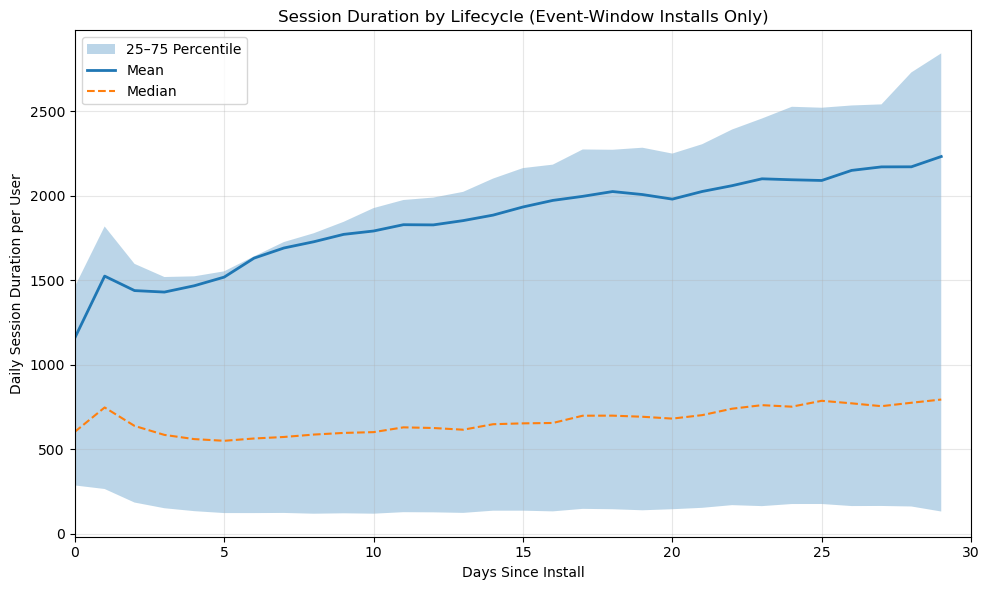

Lifecycle Trend Slope: 29.3025961355109


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure datetime
df["event_date"] = pd.to_datetime(df["event_date"])
df["install_date"] = pd.to_datetime(df["install_date"])

# 1️⃣ Restrict installs to event window

min_event = df["event_date"].min()
max_event = df["event_date"].max()

df_filtered = df[
    (df["install_date"] >= min_event) &
    (df["install_date"] <= max_event)
    ].copy()

# 2️⃣ Compute lifecycle

df_filtered["days_since_install"] = (
        df_filtered["event_date"] - df_filtered["install_date"]
).dt.days

df_filtered = df_filtered[df_filtered["days_since_install"] >= 0]

# 3️⃣ Aggregate per user per lifecycle day

user_day_duration = (
    df_filtered
    .groupby(["user_id", "days_since_install"])["total_session_duration"]
    .sum()
    .reset_index()
)

# 4️⃣ Lifecycle statistics

lifecycle_stats = (
    user_day_duration
    .groupby("days_since_install")["total_session_duration"]
    .agg(
        p25=lambda x: x.quantile(0.25),
        median="median",
        p75=lambda x: x.quantile(0.75),
        mean="mean"
    )
    .reset_index()
)

# 5️⃣ Plot

plt.figure(figsize=(10,6))

plt.fill_between(
    lifecycle_stats["days_since_install"],
    lifecycle_stats["p25"],
    lifecycle_stats["p75"],
    alpha=0.3,
    label="25–75 Percentile"
)

plt.plot(
    lifecycle_stats["days_since_install"],
    lifecycle_stats["mean"],
    linewidth=2,
    label="Mean"
)

plt.plot(
    lifecycle_stats["days_since_install"],
    lifecycle_stats["median"],
    linestyle="--",
    label="Median"
)

plt.xlabel("Days Since Install")
plt.ylabel("Daily Session Duration per User")
plt.title("Session Duration by Lifecycle (Event-Window Installs Only)")

plt.xlim(0, 30)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 6️⃣ Trend slope

coef = np.polyfit(
    lifecycle_stats["days_since_install"],
    lifecycle_stats["mean"],
    1
)

print("Lifecycle Trend Slope:", coef[0])

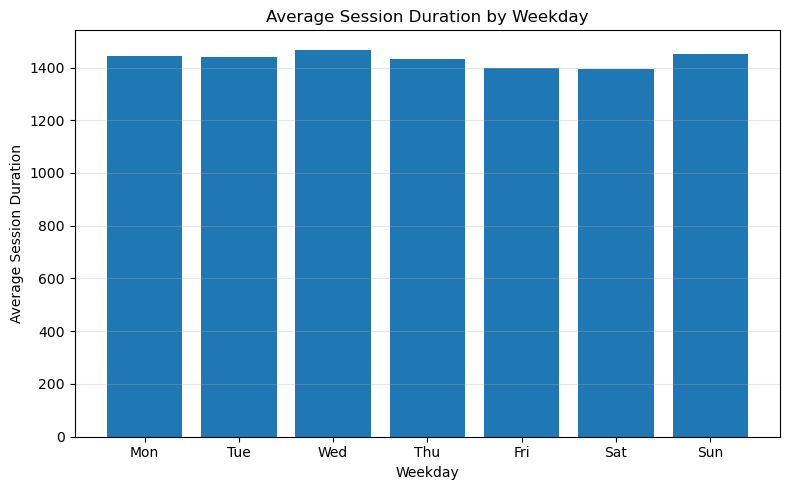

In [31]:
import matplotlib.pyplot as plt

# Create weekday column
df_filtered["weekday"] = df_filtered["event_date"].dt.weekday

# Compute mean session duration by weekday
weekday_duration = (
    df_filtered
    .groupby("weekday")["total_session_duration"]
    .mean()
)

# Map weekday numbers to names
weekday_map = {
    0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu",
    4: "Fri", 5: "Sat", 6: "Sun"
}

weekday_duration.index = weekday_duration.index.map(weekday_map)

plt.figure(figsize=(8,5))

plt.bar(weekday_duration.index, weekday_duration.values)

plt.xlabel("Weekday")
plt.ylabel("Average Session Duration")
plt.title("Average Session Duration by Weekday")

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

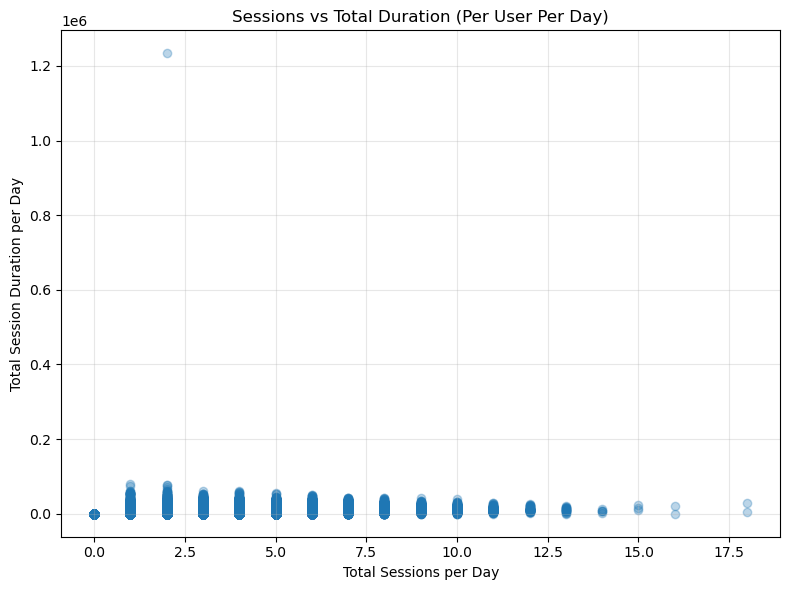

In [32]:
# Compute per-user-per-day aggregation
session_vs_duration = (
    df_filtered
    .groupby(["user_id", "event_date"])
    .agg(
        sessions=("total_session_count", "sum"),
        duration=("total_session_duration", "sum")
    )
    .reset_index()
)

plt.figure(figsize=(8,6))

plt.scatter(
    session_vs_duration["sessions"],
    session_vs_duration["duration"],
    alpha=0.3
)

plt.xlabel("Total Sessions per Day")
plt.ylabel("Total Session Duration per Day")
plt.title("Sessions vs Total Duration (Per User Per Day)")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()